In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, precision_score, recall_score, r2_score, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

import optuna

from joblib import Parallel, delayed
from sklearn.neighbors import BallTree

# Регрессия

In [2]:
RAW_FEATS = 'regression_raw_feats.csv'
RAW_TARGET = 'regression_raw_target.csv'
PROCESSED_FEATS = 'regression_processed_feats.csv'
PROCESSED_TARGET = 'regression_processed_target.csv'

In [3]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [4]:
def evaluate(metrics, y_test, y_pred, round_num):
    for metric in metrics:
        print(f'Model score for metric "{metric.__name__}": {round(metric(y_test, y_pred), round_num)}')

    plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
    line_coords = np.linspace(np.min(y_test), np.max(y_test), 100)
    plt.plot(line_coords, line_coords, color='red', linestyle='--', linewidth=2, label='Perfect prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.title('Actual vs predicted values')
    plt.legend()
    plt.grid(True)
    plt.show()

In [5]:
eval_metrics = [mean_absolute_error, root_mean_squared_error, r2_score]
optuna_metric = root_mean_squared_error
random_state = 42
test_size = 0.2

round_num = 4

n_trials = 10
cv = 5

## Готовая модель

In [6]:
model_class = KNeighborsRegressor

### Бейзлайн

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [8]:
model = model_class(n_jobs=-1)

model.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [9]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 3.5276
Model score for metric "root_mean_squared_error": 5.5553
Model score for metric "r2_score": 0.2955


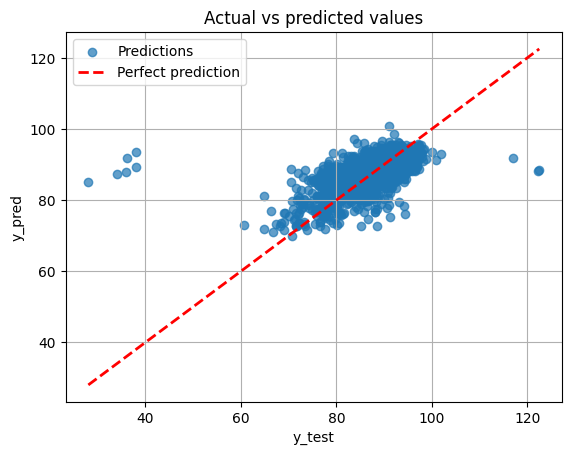

In [10]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [12]:
model = model_class(n_jobs=-1)

model.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [13]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.4665
Model score for metric "root_mean_squared_error": 3.659
Model score for metric "r2_score": 0.5807


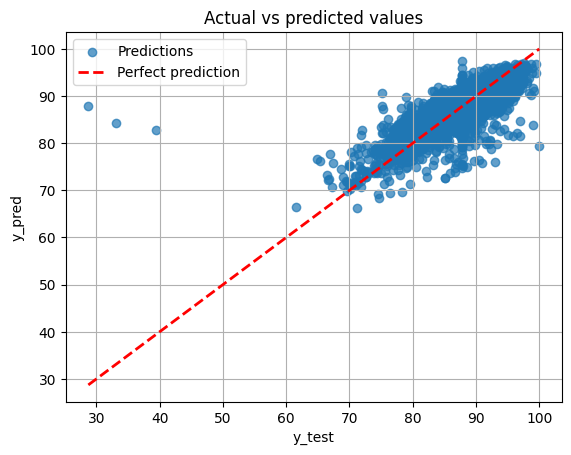

In [14]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [15]:
def objective(trial):
    knn_params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),
        'n_jobs': -1,
    }

    trial_model = model_class(**knn_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-07 13:30:25,114] A new study created in memory with name: no-name-9d595fb8-eda9-4ff1-a8f9-8d7c82198198
[I 2025-12-07 13:30:26,669] Trial 0 finished with value: 4.4519533944553515 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 4.4519533944553515.
[I 2025-12-07 13:30:27,823] Trial 1 finished with value: 4.540207477907758 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 4.4519533944553515.
[I 2025-12-07 13:30:28,821] Trial 2 finished with value: 4.428652684240504 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 4.428652684240504.
[I 2025-12-07 13:30:29,008] Trial 3 finished with value: 4.439902324588777 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 4.428652684240504.
[I 2025-12-07 13:30:29,152] Trial 4 finished with value: 4.467973758848504 and parameters: {'n_neighbors': 17, 'weights': 'unif

Лучшие параметры для модели: {'n_neighbors': 31, 'weights': 'uniform', 'p': 2}
Лучшая метрика (root_mean_squared_error): 4.4287


KNeighborsRegressor(n_neighbors=31)

In [16]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.2737
Model score for metric "root_mean_squared_error": 3.3039
Model score for metric "r2_score": 0.6581


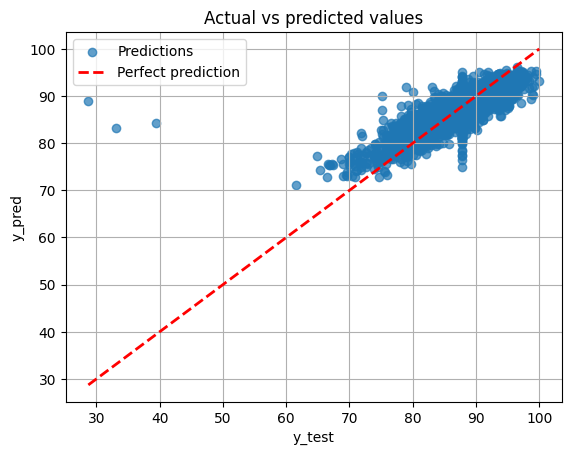

In [17]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

## Своя модель

In [ ]:
class MyKNNRegressor:
    """
    Uses only numpy, no parallel capabilities.

    Parameters
    -----------
    n_neighbors : int, default=5
    weights : {'uniform', 'distance'}, default='uniform'
    p : int, default=2
    """

    def __init__(self, n_neighbors: int = 5, weights: str = 'uniform', p: int = 2):
        if n_neighbors <= 0:
            raise ValueError("n_neighbors must be a positive integer.")
        if weights not in ['uniform', 'distance']:
            raise ValueError("weights must be 'uniform' or 'distance'.")
        if p < 1:
            raise ValueError("p must be a positive integer.")

        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self._X_train = None
        self._y_train = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._X_train = np.asarray(X)
        self._y_train = np.asarray(y)
        if self._X_train.shape[0] != self._y_train.shape[0]:
            raise ValueError("Number of samples in X and y must be equal.")
        return self

    def _predict_one(self, x_test_point: np.ndarray) -> float:
        distances = np.linalg.norm(self._X_train - x_test_point, ord=self.p, axis=1)

        neighbor_indices = np.argsort(distances)[:self.n_neighbors]

        neighbor_targets = self._y_train[neighbor_indices]

        if self.weights == 'uniform':
            prediction = np.mean(neighbor_targets)
        elif self.weights == 'distance':
            neighbor_distances = distances[neighbor_indices]
            weights_array = 1 / (neighbor_distances + 1e-9)
            normalized_weights = weights_array / np.sum(weights_array)
            prediction = np.dot(normalized_weights, neighbor_targets)

        return prediction

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self._X_train is None:
            raise RuntimeError("You must call fit() before predict().")

        X_test = np.asarray(X)
        predictions = np.array([self._predict_one(x_test_point) for x_test_point in X_test])
        return predictions

    def get_params(self, deep: bool = True) -> dict:
        return {
            'n_neighbors': self.n_neighbors,
            'weights': self.weights,
            'p': self.p,
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyKNNRegressor")
        return self

In [ ]:
model_class = MyKNNRegressor

### Бейзлайн

In [20]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [21]:
model = model_class()

model.fit(X_train, y_train)

In [22]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 3.5276
Model score for metric "root_mean_squared_error": 5.5553
Model score for metric "r2_score": 0.2955


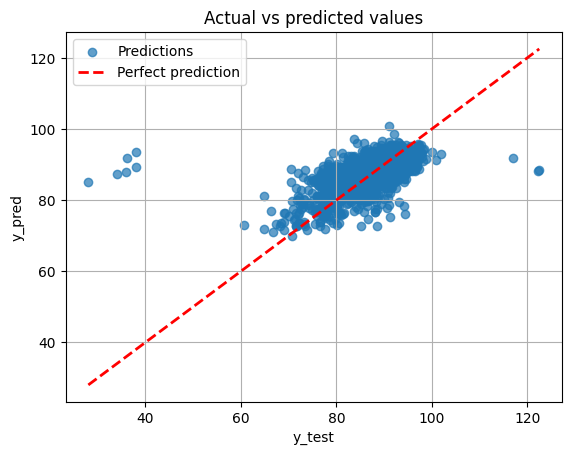

In [23]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Вывод: результат почти равен библиотечной модели, с точностью до 1е-4!

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [25]:
model = model_class()

model.fit(X_train, y_train)

In [26]:
y_pred = model.predict(X_test)

Model score for metric "mean_absolute_error": 2.4665
Model score for metric "root_mean_squared_error": 3.659
Model score for metric "r2_score": 0.5807


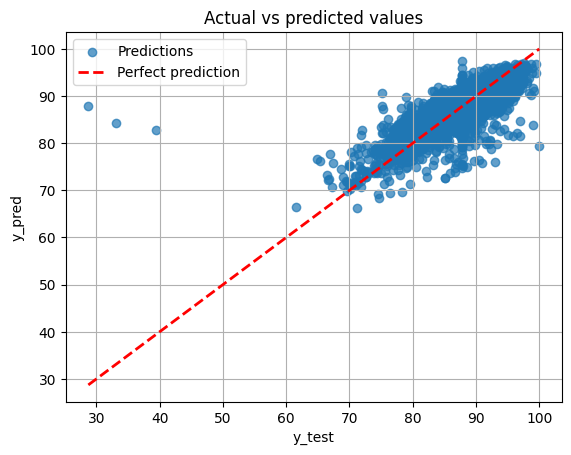

In [27]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Вывод: результат почти равен библиотечной модели, с точностью до 1е-4!

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [28]:
def objective(trial):
    knn_params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2)
    }

    trial_model = model_class(**knn_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-07 13:30:32,002] A new study created in memory with name: no-name-78a9535e-c317-4ff1-b731-64a53f5d5dba
[I 2025-12-07 13:30:32,877] Trial 0 finished with value: 4.4519533944553515 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 4.4519533944553515.
[I 2025-12-07 13:30:33,702] Trial 1 finished with value: 4.540207477907758 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 4.4519533944553515.
[I 2025-12-07 13:30:34,538] Trial 2 finished with value: 4.428652684240504 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 4.428652684240504.
[I 2025-12-07 13:30:35,316] Trial 3 finished with value: 4.439902324588777 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1}. Best is trial 2 with value: 4.428652684240504.
[I 2025-12-07 13:30:36,090] Trial 4 finished with value: 4.467973758848504 and parameters: {'n_neighbors': 17, 'weights': 'unif

Лучшие параметры для модели: {'n_neighbors': 31, 'weights': 'uniform', 'p': 2}
Лучшая метрика (root_mean_squared_error): 4.4287


In [29]:
y_pred = best_model.predict(X_test)

Model score for metric "mean_absolute_error": 2.2737
Model score for metric "root_mean_squared_error": 3.3039
Model score for metric "r2_score": 0.6581


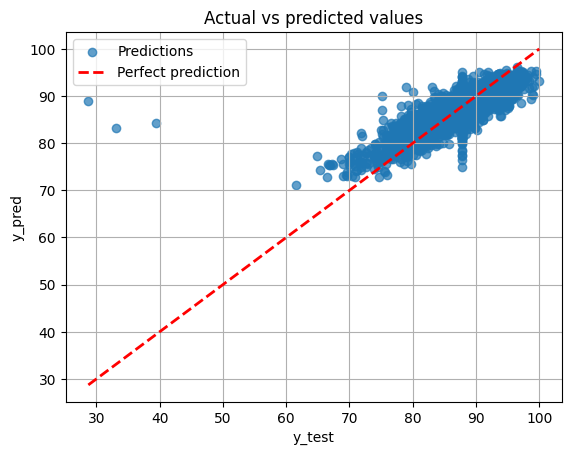

In [30]:
evaluate(metrics=eval_metrics, y_test=y_test, y_pred=y_pred, round_num=round_num)

Вывод: результат почти равен библиотечной модели, с точностью до 1е-4! Можно сказать, что модели эквивалентны.

# Классификация

In [31]:
RAW_FEATS = 'classification_raw_feats.csv'
RAW_TARGET = 'classification_raw_target.csv'
PROCESSED_FEATS = 'classification_processed_feats.csv'
PROCESSED_TARGET = 'classification_processed_target.csv'

In [32]:
df_feats_raw = pd.read_csv(RAW_FEATS)
df_target_raw = pd.read_csv(RAW_TARGET)
df_feats_processed = pd.read_csv(PROCESSED_FEATS)
df_target_processed = pd.read_csv(PROCESSED_TARGET)

In [33]:
def evaluate(y_test, y_pred_class, y_pred_proba, round_num):

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

    print(f"ROC AUC: {round(roc_auc,round_num)}", '\n')

    f1 = f1_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)

    print(f"Precision: {round(precision,round_num)}")
    print(f"Recall: {round(recall,round_num)}")
    print(f"F1-Score: {round(f1,round_num)}")

    plt.plot(fpr, tpr, label=f'ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt = 'd', cmap='Blues', cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

In [34]:
eval_metrics = [f1_score, roc_auc_score]
optuna_metric = f1_score
random_state = 42
test_size = 0.2

round_num = 4

n_trials = 5
cv = 3

## Готовая модель

In [35]:
model_class = KNeighborsClassifier

### Бейзлайн

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [37]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [38]:
model = model_class(n_jobs=-1)

model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [39]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.8037 

Precision: 0.7949
Recall: 0.3133
F1-Score: 0.4495


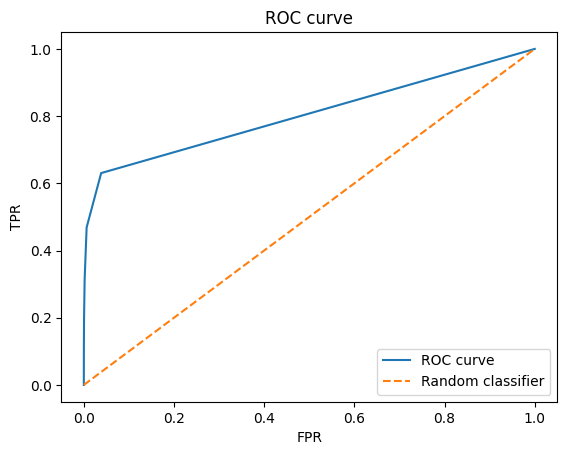

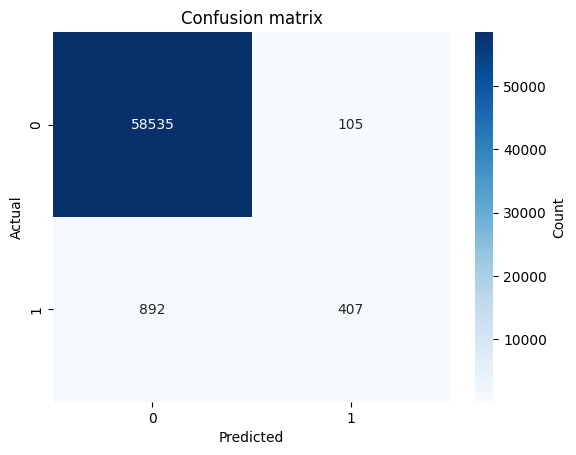

In [40]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [41]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [42]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [43]:
model = model_class(n_jobs=-1)

model.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [44]:
y_pred_class = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.8809 

Precision: 0.8691
Recall: 0.5674
F1-Score: 0.6865


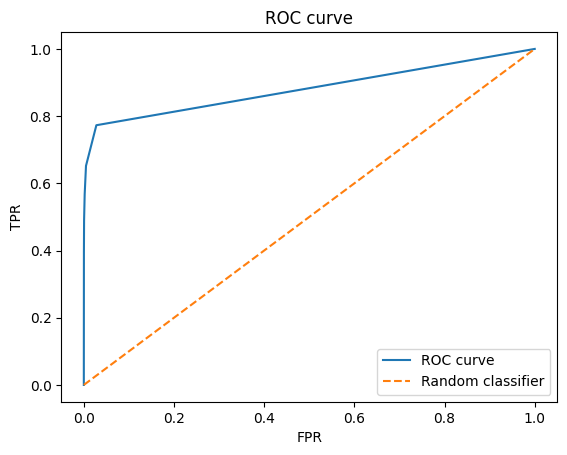

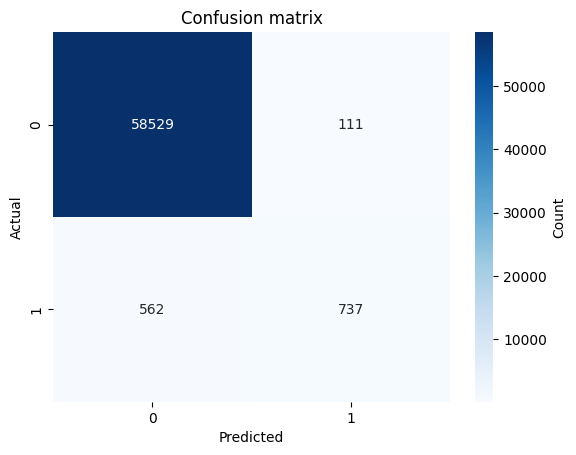

In [45]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [46]:
def objective(trial):
    knn_params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),
        'n_jobs': -1,
    }

    trial_model = model_class(**knn_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-07 13:30:54,335] A new study created in memory with name: no-name-bf3f737a-7754-413b-af9e-e56ce071fade
[I 2025-12-07 13:31:08,639] Trial 0 finished with value: 0.6566768634493519 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.6566768634493519.
[I 2025-12-07 13:31:19,895] Trial 1 finished with value: 0.6625962978225267 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.6625962978225267.
[I 2025-12-07 13:31:36,481] Trial 2 finished with value: 0.6513358886542834 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.6625962978225267.
[I 2025-12-07 13:32:00,739] Trial 3 finished with value: 0.6493782454792875 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.6625962978225267.
[I 2025-12-07 13:32:17,696] Trial 4 finished with value: 0.6796202123224416 and parameters: {'n_neighbors': 17, 'weights':

Лучшие параметры для модели: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}
Лучшая метрика (f1_score): 0.6796


KNeighborsClassifier(n_neighbors=17, p=1)

In [47]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9294 

Precision: 0.9057
Recall: 0.5473
F1-Score: 0.6823


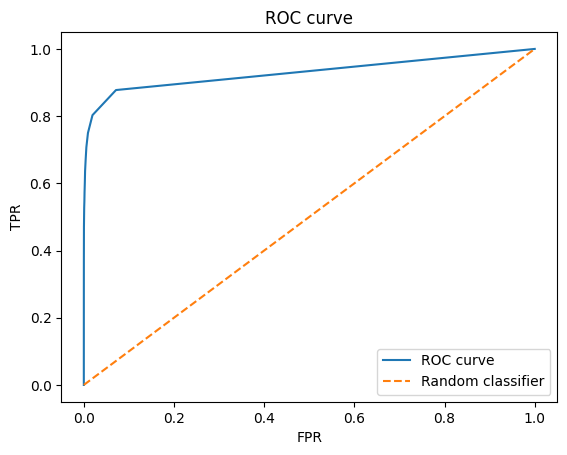

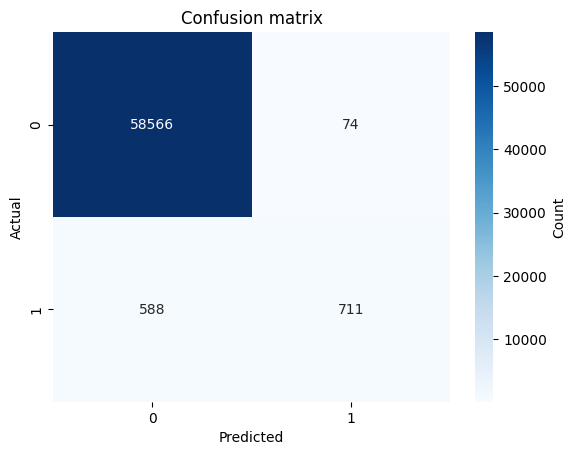

In [48]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

## Своя модель

In [ ]:
class MyKNNClassifier:
    """
    Mainly uses numpy, also BallTree and joblib for optimization of prediction speed.

    Parameters
    -----------
    n_neighbors : int, default=5
    weights : {'uniform', 'distance'}, default='uniform'
    p : int, default=2
    n_jobs : int, default=None
    """

    def __init__(self, n_neighbors: int = 5, weights: str = 'uniform', p: int = 2, n_jobs: int = None):
        if n_neighbors <= 0:
            raise ValueError("n_neighbors must be a positive integer.")
        if weights not in ['uniform', 'distance']:
            raise ValueError("weights must be 'uniform' or 'distance'.")
        if p < 1:
            raise ValueError("p must be a positive integer.")

        self.n_neighbors = n_neighbors
        self.weights = weights
        self.p = p
        self.n_jobs = n_jobs
        self.tree_ = None 
        self._y_train = None
        self.classes_ = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'MyKNNClassifier':
        X_train = np.asarray(X)
        self._y_train = np.asarray(y)
        if X_train.shape[0] != self._y_train.shape[0]:
            raise ValueError("Number of samples in X and y must be equal.")
        
        self.classes_ = np.unique(self._y_train)
        
        self.tree_ = BallTree(X_train, p=self.p)
        
        return self

    def _predict_one(self, x_test_point: np.ndarray) -> int:
        if self.tree_ is None:
            raise RuntimeError("You must call fit() before predict().")
             
        distances, neighbor_indices = self.tree_.query(
            x_test_point.reshape(1, -1), 
            k=self.n_neighbors
        )

        neighbor_distances = distances.flatten()
        neighbor_indices = neighbor_indices.flatten()
        neighbor_labels = self._y_train[neighbor_indices]

        if self.weights == 'uniform':
            counts = np.bincount(neighbor_labels)
            prediction = np.argmax(counts)
        
        elif self.weights == 'distance':
            weights = 1.0 / (neighbor_distances + 1e-9)
            
            weighted_votes = {}
            for label, weight in zip(neighbor_labels, weights):
                weighted_votes[label] = weighted_votes.get(label, 0) + weight
            
            prediction = max(weighted_votes, key=weighted_votes.get)
        
        return prediction

    def _predict_proba_one(self, x_test_point: np.ndarray) -> np.ndarray:
        if self.tree_ is None:
            raise RuntimeError("You must call fit() before predict().")
             
        n_classes = len(self.classes_)
        
        distances, neighbor_indices = self.tree_.query(
            x_test_point.reshape(1, -1), 
            k=self.n_neighbors
        )
        
        neighbor_distances = distances.flatten()
        neighbor_indices = neighbor_indices.flatten()
        neighbor_labels = self._y_train[neighbor_indices]

        prob_vector = np.zeros(n_classes)

        for j, cls in enumerate(self.classes_):
            indices = np.where(neighbor_labels == cls)[0]
            count = len(indices)
            
            if self.weights == 'uniform':
                prob = (count + 1.0) / (self.n_neighbors + n_classes)
            elif self.weights == 'distance':
                inv_dist_sum = np.sum(1.0 / (neighbor_distances[indices] + 1e-9))
                prob = (inv_dist_sum + 1.0) / (self.n_neighbors + n_classes)
            
            prob_vector[j] = prob
            
        return prob_vector

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.tree_ is None:
            raise RuntimeError("You must call fit() before predict().")
        
        X_test = np.asarray(X)
        
        predictions = Parallel(n_jobs=self.n_jobs, require='sharedmem')(
            delayed(self._predict_one)(x) for x in X_test
        )
        
        return np.array(predictions)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        if self.tree_ is None:
            raise RuntimeError("You must call fit() before predict().")
        
        X_test = np.asarray(X)
        
        probabilities = Parallel(n_jobs=self.n_jobs, require='sharedmem')(
            delayed(self._predict_proba_one)(x) for x in X_test
        )
        
        return np.array(probabilities)

    def get_params(self, deep: bool = True) -> dict:
        return {
            'n_neighbors': self.n_neighbors,
            'weights': self.weights,
            'p': self.p,
            'n_jobs': self.n_jobs
        }

    def set_params(self, **params):
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Invalid parameter {key} for MyKNNClassifier")
        return self

In [ ]:
model_class = MyKNNClassifier

### Бейзлайн

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_raw, df_target_raw, test_size = test_size, random_state = random_state)

In [52]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [53]:
model = model_class(n_jobs=-1)

model.fit(X_train, y_train)

In [54]:
y_pred_class = model.predict(X_test)

In [55]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.8037 

Precision: 0.7949
Recall: 0.3133
F1-Score: 0.4495


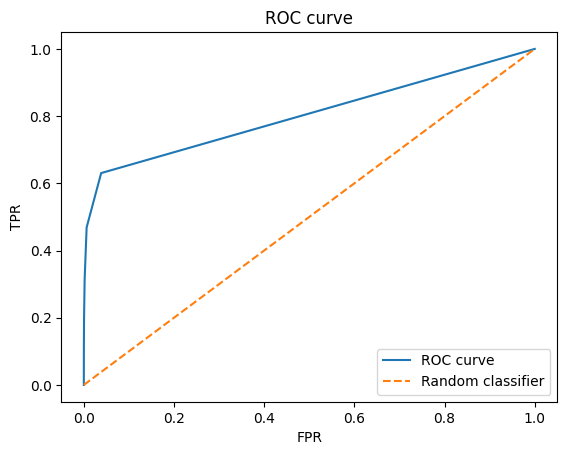

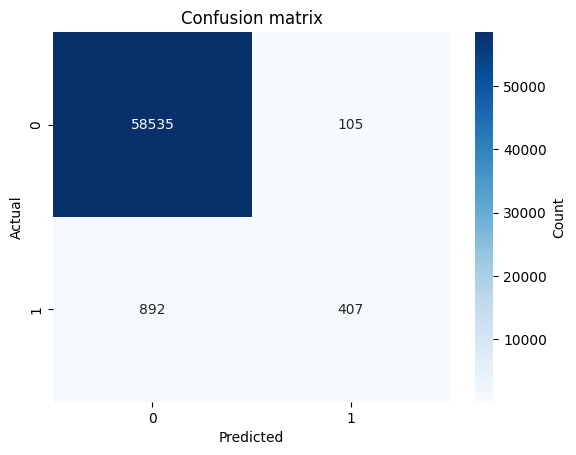

In [56]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Такой же результат, что и у библиотечной модели (с точностью 1е-4).

### Улучшенный бейзлайн

#### Улучшение за счёт препроцессинга

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_feats_processed, df_target_processed, test_size = test_size, random_state = random_state)

In [58]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [59]:
model = model_class(n_jobs=-1)

model.fit(X_train, y_train)

In [60]:
y_pred_class = model.predict(X_test)

In [61]:
y_pred_proba = model.predict_proba(X_test)

ROC AUC: 0.8809 

Precision: 0.8691
Recall: 0.5674
F1-Score: 0.6865


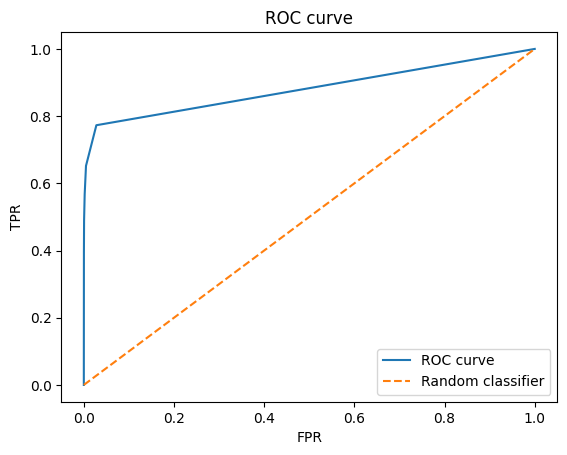

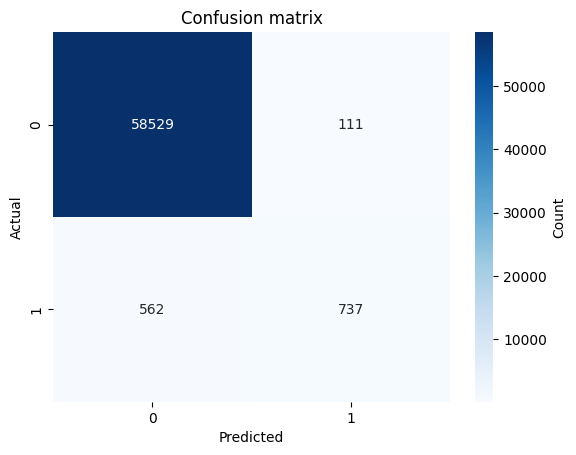

In [62]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Аналогично, результаты совпадают

#### Дополнительное улучшение за счёт подбора параметров на cross-val

In [ ]:
def objective(trial):
    knn_params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 50),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'p': trial.suggest_int('p', 1, 2),
        'n_jobs': trial.suggest_categorical('n_jobs', [-1]),
    }

    trial_model = model_class(**knn_params)
    
    score = cross_val_score(trial_model, X_train, y_train, cv=cv, scoring=make_scorer(optuna_metric), n_jobs=-1).mean()
    
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=random_state))
study.optimize(objective, n_trials=n_trials)

print(f"Лучшие параметры для модели: {study.best_params}")
print(f"Лучшая метрика ({optuna_metric.__name__}): {round(study.best_value,round_num)}")

best_model = model_class(**study.best_params)
best_model.fit(X_train, y_train)

[I 2025-12-07 13:35:42,572] A new study created in memory with name: no-name-8c4b68fd-a71d-44ba-a970-d47ed0807398
[I 2025-12-07 13:39:23,474] Trial 0 finished with value: 0.6562508666538212 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.6562508666538212.
[I 2025-12-07 13:42:42,960] Trial 1 finished with value: 0.6618990322814772 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.6618990322814772.
[I 2025-12-07 13:46:05,529] Trial 2 finished with value: 0.6513064515517079 and parameters: {'n_neighbors': 31, 'weights': 'uniform', 'p': 2}. Best is trial 1 with value: 0.6618990322814772.
[I 2025-12-07 13:49:20,827] Trial 3 finished with value: 0.6495811455578345 and parameters: {'n_neighbors': 42, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.6618990322814772.
[I 2025-12-07 13:52:14,386] Trial 4 finished with value: 0.6792836445016818 and parameters: {'n_neighbors': 17, 'weights':

Лучшие параметры для модели: {'n_neighbors': 17, 'weights': 'uniform', 'p': 1}
Лучшая метрика (f1_score): 0.6793


In [64]:
y_pred_class = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

ROC AUC: 0.9294 

Precision: 0.9057
Recall: 0.5473
F1-Score: 0.6823


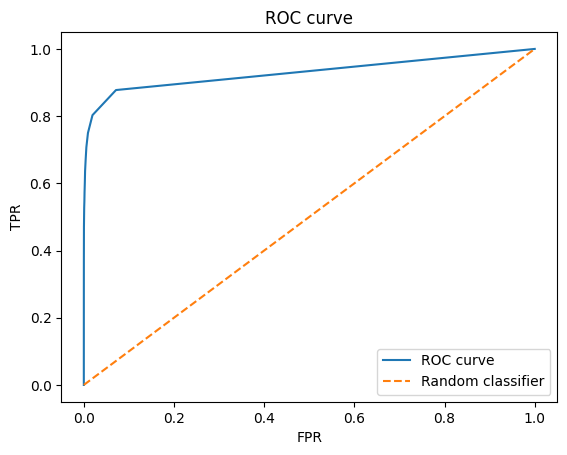

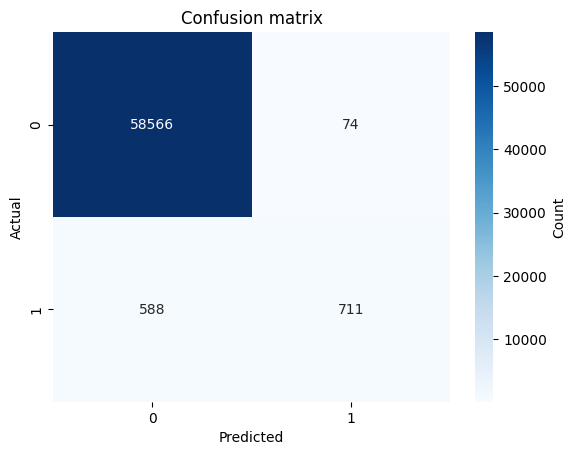

In [65]:
evaluate(y_test=y_test, y_pred_class=y_pred_class, y_pred_proba=y_pred_proba, round_num=round_num)

Результаты совпадают.

# Выводы

Кастомные реализации KNN показали результаты, идентичные библиотечным моделям. Для регрессии (15000 строк) оказалось достаточно простого использования numpy. Для классификации (300 000 строк) пришлось выполнять распараллеливание и находить расстояния через BallTree.

Предобработка данных и подбор гиперпараметров через Optuna с кросс-валидацией показали хороший прирост по метрикам.